<a href="https://colab.research.google.com/github/BMugo84/pytorch_in_25_hours/blob/main/attn_is_all_you_need_Shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Notes

We build a Generatively Pretrained Transformer (GPT), following the paper "Attention is All You Need" and OpenAI's GPT-2 / GPT-3. We talk about connections to ChatGPT, which has taken the world by storm. We watch GitHub Copilot, itself a GPT, help us write a GPT (meta :D!) . I recommend people watch the earlier makemore videos to get comfortable with the autoregressive language modeling framework and basics of tensors and PyTorch nn, which we take for granted in this video.

Links:
- Google colab for the video: https://colab.research.google.com/dri...
- GitHub repo for the video: https://github.com/karpathy/ng-video-...
- Playlist of the whole Zero to Hero series so far:    • The spelled-out intro to neural netwo...  
- nanoGPT repo: https://github.com/karpathy/nanoGPT
- my website: https://karpathy.ai
- my twitter:   / karpathy  
- our Discord channel:   / discord  

Supplementary links:
- Attention is All You Need paper: https://arxiv.org/abs/1706.03762
- OpenAI GPT-3 paper: https://arxiv.org/abs/2005.14165
- OpenAI ChatGPT blog post: https://openai.com/blog/chatgpt/
- The GPU I'm training the model on is from Lambda GPU Cloud, I think the best and easiest way to spin up an on-demand GPU instance in the cloud that you can ssh to: https://lambdalabs.com . If you prefer to work in notebooks, I think the easiest path today is Google Colab.

Suggested exercises:
- EX1: The n-dimensional tensor mastery challenge: Combine the `Head` and `MultiHeadAttention` into one class that processes all the heads in parallel, treating the heads as another batch dimension (answer is in nanoGPT).
- EX2: Train the GPT on your own dataset of choice! What other data could be fun to blabber on about? (A fun advanced suggestion if you like: train a GPT to do addition of two numbers, i.e. a+b=c. You may find it helpful to predict the digits of c in reverse order, as the typical addition algorithm (that you're hoping it learns) would proceed right to left too. You may want to modify the data loader to simply serve random problems and skip the generation of train.bin, val.bin. You may want to mask out the loss at the input positions of a+b that just specify the problem using y=-1 in the targets (see CrossEntropyLoss ignore_index). Does your Transformer learn to add? Once you have this, swole doge project: build a calculator clone in GPT, for all of +-*/. Not an easy problem. You may need Chain of Thought traces.)
- EX3: Find a dataset that is very large, so large that you can't see a gap between train and val loss. Pretrain the transformer on this data, then initialize with that model and finetune it on tiny shakespeare with a smaller number of steps and lower learning rate. Can you obtain a lower validation loss by the use of pretraining?
- EX4: Read some transformer papers and implement one additional feature or change that people seem to use. Does it improve the performance of your GPT?


### 00:00:00 Intro: ChatGPT, Transformers, nanoGPT, Shakespeare  Baseline Language Modeling, Code Setup 00:07:52 Reading and Exploring the Data


In [1]:
# Download the dataset tiny Shakespear Dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-10-19 13:02:17--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2024-10-19 13:02:17 (20.6 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [2]:
# read it in to inspect it
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [3]:
print("Length of dataset in characters: ", len(text))

Length of dataset in characters:  1115394


In [4]:
# looking at the first 1000 chars
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


### 00:09:28 Tokenization, Train/Val Split


In [5]:
# Check all unique characters in the test
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(len(chars))


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
# create a mapping for characters to integers
stoi = {ch:i for i, ch in enumerate(chars)} # string to integer
itos = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # ie take a string , output a list of integers
decode = lambda l: "".join([itos[i] for i in l]) # ie take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [7]:
# # expanding the top code
# stoi = {}
# for i,ch in enumerate(chars):
#     stoi[ch] = i
# itos = {}
# for i, ch in enumerate(chars):
#     itos[i] = ch

# def encodetst(s):
#     intlist = []
#     for c in s:
#         intlist.append(stoi[c])
#     return intlist
# def decodetst(l):
#     strlist = []
#     for i in l:
#         strlist.append(itos[i])
#     return "".join(strlist)

# print(encodetst("hii there"))
# print(decodetst(encodetst("hii there")))

In [8]:
# testing tiktoken
!pip install tiktoken

import tiktoken
enc = tiktoken.get_encoding("o200k_base")
assert enc.decode(enc.encode("hello world")) == "hello world"

# To get the tokeniser corresponding to a specific model in the OpenAI API:
enc = tiktoken.encoding_for_model("gpt-4o")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.6 MB/s eta 0:00:00


In [9]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")
print(enc.encode("hii there"))

[71, 4178, 612]


In [10]:
# lets now encode the entire text dataset and store it into a torch.Tensor
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [11]:
# lets split the data into train and test datasets/validation
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

### 00:14:27 Data Loader: Batches of Chunks of Data


In [12]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [13]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58




1. Setup:
   - Block size = 8 (max context length)
   - Batch size = 4 (parallel sequences)

2. Data Selection:
   - Choose train or val data
   - Think of data as one long string of characters

3. Batch Creation:
   - Pick 4 random starting points in the data
   - For each starting point:
     * Input (X): Take 8 characters
     * Target (Y): Take next 8 characters (offset by 1)

4. Resulting Structure:
   X (inputs):          Y (targets):
   [char1, char2, ...] [char2, char3, ...]
   [char1, char2, ...] [char2, char3, ...]
   [char1, char2, ...] [char2, char3, ...]
   [char1, char2, ...] [char2, char3, ...]

5. Training Examples:
   For each row:
     Context    Target
     c          h
     ch         a
     cha        r
     char       3
     ... (up to 8 characters)

6. Key Points:
   - 32 total examples (4 rows * 8 positions)
   - Context grows from 1 to 8 characters
   - Target is always the next character
   - Model learns to predict next char given varying context lengths

This structure allows efficient training on multiple sequences with various context lengths simultaneously.



So, when the lecturer says (B, T, C), they're referring to data with the following structure:
- **Batch**: How many sequences are being processed at once.
- **Time**: How many steps (words/tokens) are in each sequence.
- **Channel**: The number of features representing each word or token (you’ll see this when you use embeddings).



In [14]:
# introducing batch dimension
torch.manual_seed(1337)
batch_size = 4 # how many independent sequence will we process in parallel
block_size = 8 # what is the max context length for prediction

def get_batch(split):
    data = train_data if split == "train" else val_data # specify data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch("train")
print('inputs:')
print(xb.shape)
print(xb)
print('targets')
print(yb.shape)
print(yb)

print('-----')

for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")




inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
-----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

In [15]:
print(xb)

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


### 00:22:11 Simplest Baseline: Bigram Language Model, Loss, Generation




This code is for a **Bigram Language Model** built using PyTorch. The goal of this model is to predict the next word in a sentence by looking at the current word. Let’s walk through the key elements:

1. **Setting up PyTorch**:
   - We first import PyTorch (`torch`), some neural network modules (`nn`), and set a manual seed to ensure reproducibility.

2. **Defining the Model**:
   - The class `BigramLanguageModel` is created as a type of neural network model (`nn.Module`).
   - Inside the model’s `__init__` function, we initialize an embedding table (`self.token_embedding_table`) that converts words (or tokens) into vectors. This is like a dictionary where each word is assigned a unique vector.
   - `vocab_size` tells the model how many unique words it should consider.

3. **Forward Function**:
   - The `forward` method is where the model does its main work. It takes in two inputs, `idx` (the current word indices) and `targets` (the next word indices, which we want to predict).
   - The `self.token_embedding_table(idx)` converts the word indices (`idx`) into their corresponding vector representations. The result, `logits`, contains information about the likelihood of the next word in the sequence.

4. **Output**:
   - Finally, the model produces an output with a shape that corresponds to the batch size (`B`), the number of tokens in the sequence (`T`), and the number of possible next words (`C`, the vocabulary size).

In simple terms, this model is learning how likely one word is to follow another by directly looking up its prediction from a table. It’s a basic building block for more complex language models.



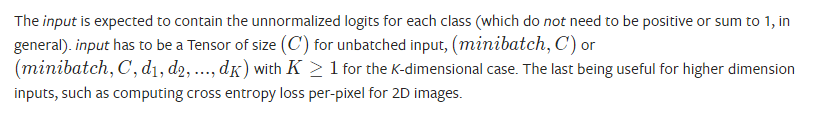

We expect our loss to be less than 4.1743 ie:

```python
import math

result = -math.log(1/65)
print(result)
```

```output
4.174387269895637

```

In [16]:
import math

result = -math.log(1/65)
print(result)


4.174387269895637


In [17]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size) # tool for converting our x inputs and y targets into vectors

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) #(B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last step
            logits = logits[:, -1, :] # from (B,T,C) to (B,C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)
            # sa,ple from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb) # pass inputs and targets
print(f"vocab_size: ",vocab_size)
print(f"logits.shape: ",logits.shape)
print(f"loss: ",loss)

# idx = torch.zeros((1,1), dtype=torch.long)
# print(decode(m.generate(idx=idx, max_new_tokens=100)[0].tolist()))
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


vocab_size:  65
logits.shape:  torch.Size([32, 65])
loss:  tensor(4.8786, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


### 00:34:53 Training the Bigram Model


In [18]:
# create a pytorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [19]:
batch_size = 32
losses = []  # List to store loss values

for steps in range(10000):
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

       # Store the loss value
    losses.append(loss.item())

    # Print loss every 1000 steps
    if steps % 1000 == 0:
        print(f'Step {steps}: Loss {loss.item():.4f}')



Step 0: Loss 4.7040
Step 1000: Loss 3.7031
Step 2000: Loss 3.1372
Step 3000: Loss 2.7768
Step 4000: Loss 2.5845
Step 5000: Loss 2.5105
Step 6000: Loss 2.5316
Step 7000: Loss 2.5048
Step 8000: Loss 2.4697
Step 9000: Loss 2.4839


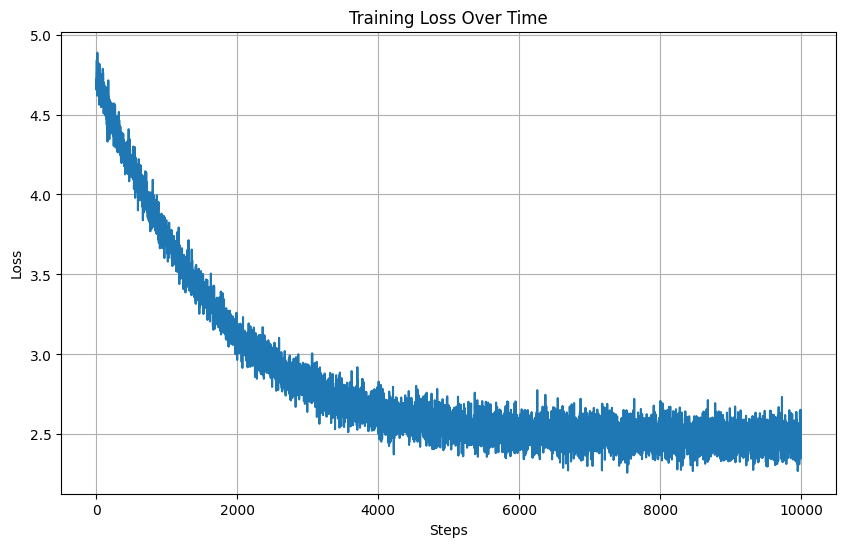

In [20]:
import matplotlib.pyplot as plt

# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss Over Time')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [21]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


Iyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henoure wounonthioneir thondy, y heltieiengerofo'dsssit ey
KIN d pe wither vouprrouthercc.
hathe; d!
My hind tt hinig t ouchos tes; st yo hind wotte grotonear 'so it t jod weancotha:
h hay.JUCle n prids, r loncave w hollular s O:
HIs; ht anjx?

DUThinqunt.

LaZAnde.
athave l.
KEONH:
ARThanco be y,-hedarwnoddy scace, tridesar, wnl'shenous s ls, theresseys
PlorseelapinghiybHen yof GLUCEN t l-t E:
I hisgothers je are!-e!
QLYotouciullle'z


### 00:38:00 Porting Our Code to a Script  Building the "Self-Attention"


In [22]:

%%writefile bigram.py
import torch
import torch.nn as nn
from torch.nn import functional as F


batch_size = 32
block_size = 8
max_iters = 3000
eval_interval = 300
learning_rate = 1e-2
device = "cuda" if torch.cuda.is_available() else "cpu"
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
#-------------

torch.manual_seed(1337)

# Download the dataset tiny Shakespear Dataset
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# read it in to inspect it
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()

print("Length of dataset in characters: ", len(text))

# Check all unique characters in the test
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(len(chars))


# create a mapping for characters to integers
stoi = {ch:i for i, ch in enumerate(chars)} # string to integer
itos = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # ie take a string , output a list of integers
decode = lambda l: "".join([itos[i] for i in l]) # ie take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))


# lets now encode the entire text dataset and store it into a torch.Tensor

data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

# lets split the data into train and test datasets/validation
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

#dataloader Batches of chunks of data


def get_batch(split):
    data = train_data if split == "train" else val_data # specify data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device) # when you load the data, make sure to move it to the device
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X,Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size) # tool for converting our x inputs and y targets into vectors

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) #(B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last step
            logits = logits[:, -1, :] # from (B,T,C) to (B,C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)
            # sa,ple from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


model = BigramLanguageModel(vocab_size)
m = model.to(device)

# create a pytorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)


losses = []  # List to store loss values

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

Writing bigram.py


In [23]:
!python bigram.py

Length of dataset in characters:  1115394

 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65
[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there
torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])
step 0: train loss 4.7305, val loss 4.7241
step 300: train loss 4.3818, val loss 4.3896
step 600: train loss 4.0801, val loss 4.0784
step 900: train loss 3.8066, val loss 3.8117
step 1200: train loss 3.5844, val loss 3.5850
step 1500: train loss 3.3757, val loss 3.3829
step 1800: train loss 3.2182, val loss 3.2218
step 2100: train loss 3.0817, val loss 3.081

### 00:42:13 Version 1: Averaging Past Context with For Loops, the Weakest Form of Aggregation


In [24]:
# consider the following toy example:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [25]:
# We want x[b,t] = mean_{i<=t} x[b,i]
torch.manual_seed(1337)
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)

In [26]:
x[0],xbow[0]

(tensor([[ 0.1808, -0.0700],
         [-0.3596, -0.9152],
         [ 0.6258,  0.0255],
         [ 0.9545,  0.0643],
         [ 0.3612,  1.1679],
         [-1.3499, -0.5102],
         [ 0.2360, -0.2398],
         [-0.9211,  1.5433]]),
 tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]))

In [27]:
xbow[0], xbow.shape

(tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]),
 torch.Size([4, 8, 2]))

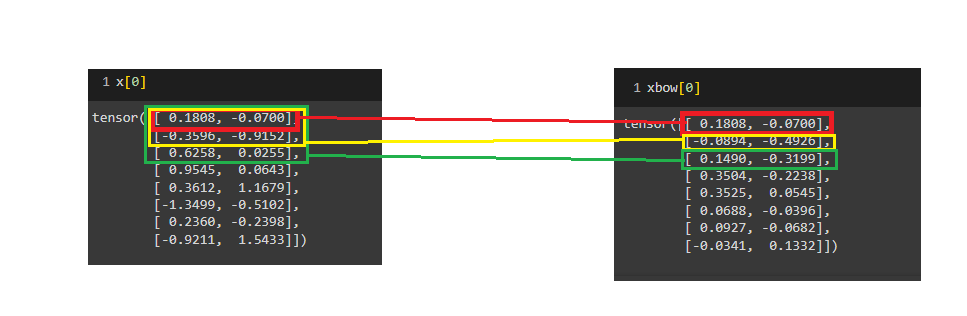

### 00:47:11 The Trick in Self-Attention: Matrix Multiply as Weighted Aggregation


In [28]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3,3))
a = a/torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a@b
print(f"a=")
print(a)
print("---------")
print(f"b=")
print(b)
print("---------")
print(f"c=")
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
---------
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
---------
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


<img src="https://raw.githubusercontent.com/BMugo84/pytorch_in_25_hours/refs/heads/main/matrix_multiplication-ezgif.com-video-to-gif-converter.gif" width=900 />

### 00:51:54 Version 2: Using Matrix Multiply


In [29]:
torch.tril(torch.ones(3,3))

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [30]:
wei = torch.tril(torch.ones(T,T))
wei = wei / wei.sum(1, keepdim=True)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [31]:
xbow2 = wei @ x # (T,T) @ (B,T,C)
xbow2[0], xbow[0]
torch.allclose(xbow, xbow2, rtol=1e-03, atol=1e-05)#check if xbow2==xbow. Sorry, the floating points on both differthus the atol/rtol

True

In [32]:
diff = torch.abs(xbow - xbow2)
print(diff.max())

tensor(3.2363e-08)


### 00:54:42 Version 3: Adding Softmax


In [33]:
tril = torch.tril(torch.ones(T, T)) # making a lower triangular matrix
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [34]:
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf')) #making a weighted triangular matrix with -inf as 0's
wei

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [35]:
wei = F.softmax(wei, dim=-1)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [36]:
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3, rtol=1e-03, atol=1e-05)

True

### 00:58:26 Minor Code Cleanup


In [37]:
%%writefile bigramv2.py
import torch
import torch.nn as nn
from torch.nn import functional as F


batch_size = 32
block_size = 8
max_iters = 3000
eval_interval = 300
learning_rate = 1e-2
device = "cuda" if torch.cuda.is_available() else "cpu"
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
#-------------

torch.manual_seed(1337)

# Download the dataset tiny Shakespear Dataset
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# read it in to inspect it
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()

print("Length of dataset in characters: ", len(text))

# Check all unique characters in the test
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(len(chars))


# create a mapping for characters to integers
stoi = {ch:i for i, ch in enumerate(chars)} # string to integer
itos = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # ie take a string , output a list of integers
decode = lambda l: "".join([itos[i] for i in l]) # ie take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))


# lets now encode the entire text dataset and store it into a torch.Tensor

data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

# lets split the data into train and test datasets/validation
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

#dataloader Batches of chunks of data


def get_batch(split):
    data = train_data if split == "train" else val_data # specify data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device) # when you load the data, make sure to move it to the device
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X,Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class BigramLanguageModel(nn.Module):
    def __init__(self): # removing vocabsize since it's a global var
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # adding emedding to map from 65 to 32
        self.lm_head = nn.Linear(n_embd, vocab_size) # remapping from 32 to 65

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) #(B,T,C)
        logits = self.lm_head(tok_emb)  #

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last step
            logits = logits[:, -1, :] # from (B,T,C) to (B,C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)
            # sa,ple from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


model = BigramLanguageModel()
m = model.to(device)

# create a pytorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)


losses = []  # List to store loss values

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

Writing bigramv2.py


In [38]:
!python bigramv2.py

Length of dataset in characters:  1115394

 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65
[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there
torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])
step 0: train loss 4.4437, val loss 4.4436
step 300: train loss 2.6719, val loss 2.6906
step 600: train loss 2.5546, val loss 2.5759
step 900: train loss 2.5231, val loss 2.5280
step 1200: train loss 2.5113, val loss 2.5179
step 1500: train loss 2.4887, val loss 2.5093
step 1800: train loss 2.4846, val loss 2.5055
step 2100: train loss 2.4812, val loss 2.498

### 01:00:18 Positional Encoding


In [39]:
%%writefile bigramv2.py
import torch
import torch.nn as nn
from torch.nn import functional as F


batch_size = 32
block_size = 8
max_iters = 3000
eval_interval = 300
learning_rate = 1e-2
device = "cuda" if torch.cuda.is_available() else "cpu"
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
#-------------

torch.manual_seed(1337)

# Download the dataset tiny Shakespear Dataset
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# read it in to inspect it
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()

print("Length of dataset in characters: ", len(text))

# Check all unique characters in the test
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(len(chars))


# create a mapping for characters to integers
stoi = {ch:i for i, ch in enumerate(chars)} # string to integer
itos = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # ie take a string , output a list of integers
decode = lambda l: "".join([itos[i] for i in l]) # ie take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))


# lets now encode the entire text dataset and store it into a torch.Tensor

data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

# lets split the data into train and test datasets/validation
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

#dataloader Batches of chunks of data


def get_batch(split):
    data = train_data if split == "train" else val_data # specify data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device) # when you load the data, make sure to move it to the device
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X,Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class BigramLanguageModel(nn.Module):
    def __init__(self): # removing vocabsize since it's a global var
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # adding emedding to map from 65 to 32
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # tracks the position of the embedding
        self.lm_head = nn.Linear(n_embd, vocab_size) # remapping from 32 to 65

    def forward(self, idx, targets=None):
        B, T = idx.shape #decode bt from idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) #(B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # T,C
        x = tok_emb + pos_emb
        logits = self.lm_head(x)  # finding the prob of token+its position

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last step
            logits = logits[:, -1, :] # from (B,T,C) to (B,C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)
            # sa,ple from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


model = BigramLanguageModel()
m = model.to(device)

# create a pytorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)


losses = []  # List to store loss values

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

Overwriting bigramv2.py


In [40]:
# !python bigramv2.py

### 01:02:00 The Crux of the Video: Version 4: Self-Attention



### **Summary**  
- **Query**: What a token (student) asks – *What info do I need?*  
- **Key**: What a token says about itself – *What info do I have?*  
- **Value**: The actual information a token holds.  
- **Attention Weights**: Calculated by matching queries with keys, determining how much attention each token gives to others.  

This mechanism allows the model to focus on relevant parts of a sequence and aggregate that information efficiently.

In [41]:
# version 4: Self attention
torch.manual_seed(1337)
B,T,C = 4,8,32
x = torch.randn(B,T,C)

tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
out = wei @ x

out.shape

torch.Size([4, 8, 32])

In [42]:
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [43]:
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [44]:
# version 5: Self attention
torch.manual_seed(1337)
B,T,C = 4,8,32
x = torch.randn(B,T,C)

# lets see a single head perform self attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
k = key(x) # (B,T,16)
q = query(x) # (B,T,16)
wei = q @ k.transpose(-2, -1) #(B,T,16) @ (B,16, T) --> (B,T,T)

tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
out = wei @ x

out.shape

torch.Size([4, 8, 32])

In [45]:
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [46]:
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

### 01:11:38 Note 1: Attention as Communication


Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

<img src="https://www.researchgate.net/profile/Benyamin-Ghojogh/publication/382124428/figure/fig5/AS:11431281260211140@1720925571435/Illustration-of-attention-of-nodes-in-a-graph_Q320.jpg" width=320 height=320 />

* Assume that every word here is a node.
* now every node has its own vector dataspace that contains the information of the vector.
* and every node has a property wei(weights) which is an aggregate of all data info nodes before it


### 01:12:46 Note 2: Attention Has No Notion of Space, Operates Over Sets


* every node by default doesn't know where they are, thats why we add positional encoding to mark every nodes position in the data


### 01:13:40 Note 3: There is No Communication Across Batch Dimension


* nodes only communicate with each other in the same batch


### 01:14:14 Note 4: Encoder Blocks vs. Decoder Blocks


### 01:15:39 Note 5: Attention vs. Self-Attention vs. Cross-Attention


### 01:16:56 Note 6: "Scaled" Self-Attention. Why Divide by sqrt(Head_Size)


In [47]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1)

In [48]:
print("k.var() --->", k.var())
print("q.var() --->", q.var())
print("wei.var() --->", wei.var())
print("torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1) --->", torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1))

k.var() ---> tensor(0.9487)
q.var() ---> tensor(1.0449)
wei.var() ---> tensor(14.3682)
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1) ---> tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])


In [49]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [50]:
print("k.var() --->", k.var())
print("q.var() --->", q.var())
print("wei.var() --->", wei.var())
print("torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1) --->", torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1))

k.var() ---> tensor(1.0700)
q.var() ---> tensor(0.9006)
wei.var() ---> tensor(1.1277)
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1) ---> tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])


### 01:19:11 Building the Transformer: Inserting a Single Self-Attention Block to Our Network


In [63]:
%%writefile bigramv2.py
import torch
import torch.nn as nn
from torch.nn import functional as F


batch_size = 32
block_size = 8
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
n_embd = 32
eval_iters = 200
# n_head = 4
# n_layer = 4
# dropout = 0.0
#-------------

torch.manual_seed(1337)

# Download the dataset tiny Shakespear Dataset
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# read it in to inspect it
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()

print("Length of dataset in characters: ", len(text))

# Check all unique characters in the test
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(len(chars))


# create a mapping for characters to integers
stoi = {ch:i for i, ch in enumerate(chars)} # string to integer
itos = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # ie take a string , output a list of integers
decode = lambda l: "".join([itos[i] for i in l]) # ie take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))


# lets now encode the entire text dataset and store it into a torch.Tensor

data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

# lets split the data into train and test datasets/validation
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

#dataloader Batches of chunks of data


def get_batch(split):
    data = train_data if split == "train" else val_data # specify data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device) # when you load the data, make sure to move it to the device
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X,Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """one head of self attention"""
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x) # (B,T,16)
        q = self.query(x) # (B,T,16)
        # compute attention scores ie affinities
        wei = q @ k.transpose(-2, -1) * C**-0.5  #(B,T,16) @ (B,16, T) --> (B,T,T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        # perform weighted aggregation of values
        v = self.value(x)
        out = wei @ v
        return out


class BigramLanguageModel(nn.Module):
    def __init__(self): # removing vocabsize since it's a global var
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # adding emedding to map from 65 to 32
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # tracks the position of the embedding
        self.sa_head = Head(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size) # remapping from 32 to 65

    def forward(self, idx, targets=None):
        B, T = idx.shape #decode bt from idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) #(B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # T,C
        x = tok_emb + pos_emb
        x = self.sa_head(x)
        logits = self.lm_head(x)  # finding the prob of token+its position

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block size
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last step
            logits = logits[:, -1, :] # from (B,T,C) to (B,C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)
            # sa,ple from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


model = BigramLanguageModel()
m = model.to(device)

# create a pytorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)


losses = []  # List to store loss values

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

Overwriting bigramv2.py


In [66]:
!python bigramv2.py

Length of dataset in characters:  1115394

 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65
[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there
torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])
step 0: train loss 4.2000, val loss 4.2047
step 500: train loss 2.6911, val loss 2.7087
step 1000: train loss 2.5196, val loss 2.5303
step 1500: train loss 2.4775, val loss 2.4829
step 2000: train loss 2.4408, val loss 2.4523
step 2500: train loss 2.4272, val loss 2.4435
step 3000: train loss 2.4130, val loss 2.4327
step 3500: train loss 2.3956, val loss 2.4

### 01:21:59 Multi-Headed Self-Attention


In [68]:
%%writefile bigramv2.py
import torch
import torch.nn as nn
from torch.nn import functional as F


batch_size = 32
block_size = 8
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
eval_iters = 200
n_embd = 32
# n_head = 4
# n_layer = 4
# dropout = 0.0
#-------------

torch.manual_seed(1337)

# Download the dataset tiny Shakespear Dataset
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# read it in to inspect it
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()

print("Length of dataset in characters: ", len(text))

# Check all unique characters in the test
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(len(chars))


# create a mapping for characters to integers
stoi = {ch:i for i, ch in enumerate(chars)} # string to integer
itos = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # ie take a string , output a list of integers
decode = lambda l: "".join([itos[i] for i in l]) # ie take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))


# lets now encode the entire text dataset and store it into a torch.Tensor

data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

# lets split the data into train and test datasets/validation
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

#dataloader Batches of chunks of data


def get_batch(split):
    data = train_data if split == "train" else val_data # specify data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device) # when you load the data, make sure to move it to the device
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X,Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """one head of self attention"""
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x) # (B,T,16)
        q = self.query(x) # (B,T,16)
        # compute attention scores ie affinities
        wei = q @ k.transpose(-2, -1) * C**-0.5  #(B,T,16) @ (B,16, T) --> (B,T,T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        # perform weighted aggregation of values
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    """multiple heads of self-attention in parallel"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size=head_size) for _ in range(num_heads)])

    def forward(self, x):
        return torch.cat([h(x) for h in self.heads], dim=-1)

class FeedForward(nn.Module):
    """a simple linear layer followed by a non-linearity"""

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)



class BigramLanguageModel(nn.Module):
    def __init__(self): # removing vocabsize since it's a global var
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # adding emedding to map from 65 to 32
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # tracks the position of the embedding
        self.sa_head = MultiHeadAttention(4, n_embd//4) # ie 4 heads of 8-dimensional self-attention
        self.ffwd = FeedForward(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size) # remapping from 32 to 65

    def forward(self, idx, targets=None):
        B, T = idx.shape #decode bt from idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) #(B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # T,C
        x = tok_emb + pos_emb
        x = self.sa_head(x)
        x = self.ffwd(x)
        logits = self.lm_head(x)  # finding the prob of token+its position

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last step
            logits = logits[:, -1, :] # from (B,T,C) to (B,C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)
            # sa,ple from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


model = BigramLanguageModel()
m = model.to(device)

# create a pytorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)


losses = []  # List to store loss values

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

Overwriting bigramv2.py


In [69]:
!python bigramv2.py

Length of dataset in characters:  1115394

 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65
[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there
torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])
step 0: train loss 4.1996, val loss 4.1995
step 500: train loss 2.5993, val loss 2.6077
step 1000: train loss 2.4629, val loss 2.4651
step 1500: train loss 2.3974, val loss 2.3951
step 2000: train loss 2.3297, val loss 2.3470
step 2500: train loss 2.3018, val loss 2.3221
step 3000: train loss 2.2828, val loss 2.2936
step 3500: train loss 2.2495, val loss 2.2

### 01:24:25 Feedforward Layers of Transformer Block


In [73]:
%%writefile bigramv2.py
import torch
import torch.nn as nn
from torch.nn import functional as F


batch_size = 32
block_size = 8
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
eval_iters = 200
n_embd = 32
# n_head = 4
# n_layer = 4
# dropout = 0.0
#-------------

torch.manual_seed(1337)

# Download the dataset tiny Shakespear Dataset
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# read it in to inspect it
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()

print("Length of dataset in characters: ", len(text))

# Check all unique characters in the test
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(len(chars))


# create a mapping for characters to integers
stoi = {ch:i for i, ch in enumerate(chars)} # string to integer
itos = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # ie take a string , output a list of integers
decode = lambda l: "".join([itos[i] for i in l]) # ie take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))


# lets now encode the entire text dataset and store it into a torch.Tensor

data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

# lets split the data into train and test datasets/validation
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

#dataloader Batches of chunks of data


def get_batch(split):
    data = train_data if split == "train" else val_data # specify data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device) # when you load the data, make sure to move it to the device
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X,Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """one head of self attention"""
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x) # (B,T,16)
        q = self.query(x) # (B,T,16)
        # compute attention scores ie affinities
        wei = q @ k.transpose(-2, -1) * C**-0.5  #(B,T,16) @ (B,16, T) --> (B,T,T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        # perform weighted aggregation of values
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    """multiple heads of self-attention in parallel"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size=head_size) for _ in range(num_heads)])

    def forward(self, x):
        return torch.cat([h(x) for h in self.heads], dim=-1)

class FeedForward(nn.Module):
    """a simple linear layer followed by a non-linearity"""

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """Transformer bloc communication followed by computation"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)

    def forward(self, x):
        x = self.sa(x)
        x = self.ffwd(x)
        return x


class BigramLanguageModel(nn.Module):
    def __init__(self): # removing vocabsize since it's a global var
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # adding emedding to map from 65 to 32
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # tracks the position of the embedding
        self.sa_head = MultiHeadAttention(4, n_embd//4) # ie 4 heads of 8-dimensional self-attention
        self.ffwd = FeedForward(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size) # remapping from 32 to 65

    def forward(self, idx, targets=None):
        B, T = idx.shape #decode bt from idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) #(B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # T,C
        x = tok_emb + pos_emb
        x = self.sa_head(x)
        x = self.ffwd(x)
        logits = self.lm_head(x)  # finding the prob of token+its position

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last step
            logits = logits[:, -1, :] # from (B,T,C) to (B,C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)
            # sa,ple from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


model = BigramLanguageModel()
m = model.to(device)

# create a pytorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)


losses = []  # List to store loss values

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

Overwriting bigramv2.py


In [74]:
!python bigramv2.py

Length of dataset in characters:  1115394

 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65
[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there
torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])
step 0: train loss 4.1996, val loss 4.1995
step 500: train loss 2.5993, val loss 2.6077
step 1000: train loss 2.4629, val loss 2.4651
step 1500: train loss 2.3974, val loss 2.3951
step 2000: train loss 2.3297, val loss 2.3470
step 2500: train loss 2.3018, val loss 2.3221
step 3000: train loss 2.2828, val loss 2.2936
step 3500: train loss 2.2495, val loss 2.2

### 01:26:48 Residual Connections


In [72]:
%%writefile bigramv2.py
import torch
import torch.nn as nn
from torch.nn import functional as F


batch_size = 32
block_size = 8
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
eval_iters = 200
n_embd = 32
# n_head = 4
# n_layer = 4
# dropout = 0.0
#-------------

torch.manual_seed(1337)

# Download the dataset tiny Shakespear Dataset
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# read it in to inspect it
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()

print("Length of dataset in characters: ", len(text))

# Check all unique characters in the test
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(len(chars))


# create a mapping for characters to integers
stoi = {ch:i for i, ch in enumerate(chars)} # string to integer
itos = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # ie take a string , output a list of integers
decode = lambda l: "".join([itos[i] for i in l]) # ie take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))


# lets now encode the entire text dataset and store it into a torch.Tensor

data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

# lets split the data into train and test datasets/validation
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

#dataloader Batches of chunks of data


def get_batch(split):
    data = train_data if split == "train" else val_data # specify data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device) # when you load the data, make sure to move it to the device
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X,Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """one head of self attention"""
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x) # (B,T,16)
        q = self.query(x) # (B,T,16)
        # compute attention scores ie affinities
        wei = q @ k.transpose(-2, -1) * C**-0.5  #(B,T,16) @ (B,16, T) --> (B,T,T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        # perform weighted aggregation of values
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    """multiple heads of self-attention in parallel"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size=head_size) for _ in range(num_heads)])

    def forward(self, x):
        return torch.cat([h(x) for h in self.heads], dim=-1)

class FeedForward(nn.Module):
    """a simple linear layer followed by a non-linearity"""

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """Transformer bloc communication followed by computation"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)

    def forward(self, x):
        x = self.sa(x)
        x = self.ffwd(x)
        return x


class BigramLanguageModel(nn.Module):
    def __init__(self): # removing vocabsize since it's a global var
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # adding emedding to map from 65 to 32
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # tracks the position of the embedding
        self.sa_head = MultiHeadAttention(4, n_embd//4) # ie 4 heads of 8-dimensional self-attention
        self.ffwd = FeedForward(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size) # remapping from 32 to 65

    def forward(self, idx, targets=None):
        B, T = idx.shape #decode bt from idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) #(B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # T,C
        x = tok_emb + pos_emb
        x = self.sa_head(x)
        x = self.ffwd(x)
        logits = self.lm_head(x)  # finding the prob of token+its position

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last step
            logits = logits[:, -1, :] # from (B,T,C) to (B,C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)
            # sa,ple from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


model = BigramLanguageModel()
m = model.to(device)

# create a pytorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)


losses = []  # List to store loss values

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

Overwriting bigramv2.py


In [75]:
!python bigramv2.py

Length of dataset in characters:  1115394

 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65
[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there
torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])
step 0: train loss 4.1996, val loss 4.1995
step 500: train loss 2.5993, val loss 2.6077
step 1000: train loss 2.4629, val loss 2.4651
step 1500: train loss 2.3974, val loss 2.3951
step 2000: train loss 2.3297, val loss 2.3470
step 2500: train loss 2.3018, val loss 2.3221
step 3000: train loss 2.2828, val loss 2.2936
step 3500: train loss 2.2495, val loss 2.2

### 01:32:51 Layernorm (and Its Relationship to Our Previous Batchnorm)


### 01:37:49 Scaling Up the Model! Creating a Few Variables, Adding Dropout


### 01:42:39 Notes on Transformer: Encoder vs. Decoder vs. Both (?) Transformers


### 01:46:22 Super Quick Walkthrough of nanoGPT, Batched Multi-Headed Self-Attention


### 01:48:53 Back to ChatGPT, GPT-3, Pretraining vs. Finetuning, RLHF


### 01:54:32 Conclusions